In [205]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from scipy.linalg import toeplitz

In [206]:
data = pd.read_excel('Input (1).xlsx',  sheet_name='China 2', header=0, na_values='')

In [207]:
data.head()

,Date,Variable,600785.SS,000589.SZ,600183.SS,000428.SZ,600057.SS,600753.SS,600758.SS,000620.SZ,...,002325.SZ,002326.SZ,300029.SZ,300032.SZ,300033.SZ,300034.SZ,300035.SZ,300036.SZ,002327.SZ,002328.SZ
0,2010,Revenue,6.047107e+08,9.448787e+08,8.325042e+08,2.084467e+08,NaN,1.495126e+06,3.127129e+07,NaN,...,2.288741e+08,7.754702e+07,6.863402e+07,3.782514e+07,3.420375e+07,5.017625e+07,2.752024e+07,3.073414e+07,1.619577e+08,1.944661e+08
1,2011,Revenue,8.407173e+08,1.197385e+09,9.337460e+08,2.597441e+08,5.391625e+09,2.024722e+05,3.511536e+07,3.912003e+08,...,3.444175e+08,1.153115e+08,1.337355e+08,4.381159e+07,2.761208e+07,6.029228e+07,3.788000e+07,4.657037e+07,2.309252e+08,2.238518e+08
2,2012,Revenue,9.630391e+08,1.058827e+09,9.779859e+08,2.640611e+08,4.711921e+09,2.264220e+06,3.865183e+07,4.073228e+08,...,4.561306e+08,1.346487e+08,2.825509e+07,5.099332e+07,3.037490e+07,7.316754e+07,3.561293e+07,4.237955e+07,2.852234e+08,2.555059e+08
3,2013,Revenue,1.091150e+09,1.070034e+09,1.085329e+09,2.941988e+08,5.848048e+09,1.781296e+06,4.380849e+07,4.296838e+08,...,5.856998e+08,1.271326e+08,3.643639e+07,7.366375e+07,4.280648e+07,8.585993e+07,4.224295e+07,5.168731e+07,3.078936e+08,4.402043e+08
4,2014,Revenue,1.098789e+09,8.966705e+08,1.195575e+09,2.440729e+08,7.798081e+09,1.954055e+06,1.064533e+09,5.642627e+08,...,5.467945e+08,1.710746e+08,2.233700e+07,1.976882e+08,2.221076e+08,9.937517e+07,3.337333e+07,5.820083e+07,3.174688e+08,5.901365e+08


In [208]:
data = pd.melt(data, id_vars=['Date', 'Variable'], var_name='RIC', value_name='value')
data

,Date,Variable,RIC,value
0,2010,Revenue,600785.SS,6.047107e+08
1,2011,Revenue,600785.SS,8.407173e+08
2,2012,Revenue,600785.SS,9.630391e+08
3,2013,Revenue,600785.SS,1.091150e+09
4,2014,Revenue,600785.SS,1.098789e+09
...,...,...,...,...
230005,2015,"Total Assets Growth, %",002328.SZ,5.825602e-01
230006,2016,"Total Assets Growth, %",002328.SZ,5.588597e-01
230007,2017,"Total Assets Growth, %",002328.SZ,2.611716e-01
230008,2018,"Total Assets Growth, %",002328.SZ,1.645199e-01


In [209]:
data = data.pivot_table('value', ['Date', 'RIC'], 'Variable')
data = data.reset_index()

In [210]:
# удаление пропусков

delete = pd.DataFrame(columns=list(data.columns))

for i in range(len(data)):
    if (math.isnan(data['Market Cap'][i]) or
        # data['Market Cap'][i] <= 5000000 or
        math.isnan(data['ROE'][i]) or
        math.isnan(data['Common Shareholder Equity'][i]) or
        math.isnan(data['Total Assets Growth, %'][i])):
        delete = delete.append(data.take([i]))
                               
delete = pd.unique(delete['RIC'])
delete = pd.DataFrame(delete)
delete = delete.rename(columns={0: 'RIC'})

data = pd.merge(data, delete, how='outer', on='RIC', indicator=True)
data = data[data['_merge'] == 'left_only']
del data['_merge']
data = data.reset_index()
del data['index']

In [211]:
data

,Date,RIC,BPS,Common Shareholder Equity,EBITDA,EPS,EV,Gross Margin,Market Cap,Net Income,Operating Profit,P_endyear,P_nextjune,ROA,ROE,ROIC,Revenue,Total Assets,"Total Assets Growth, %"
0,2010,000002.SZ,0.610456,6.712091e+09,1.778136e+09,0.100516,1.674167e+10,1.131623e+10,1.278952e+10,1.105179e+09,1.804990e+09,1.247344,1.307341,5.004789,17.848928,10.404389,7.695577e+09,3.272194e+10,0.068207
1,2011,000002.SZ,0.765400,8.415735e+09,2.492831e+09,0.139737,1.798573e+10,1.563291e+10,1.784579e+10,1.529239e+09,2.504523e+09,1.186863,1.402487,4.532460,19.804174,9.575054,1.140513e+10,4.706278e+10,0.038574
2,2012,000002.SZ,0.931735,1.024471e+10,3.380173e+09,0.184185,2.470144e+10,2.077580e+10,1.491872e+10,2.014604e+09,3.372826e+09,1.623434,1.604914,4.640698,21.492975,9.997056,1.655130e+10,6.080185e+10,0.015341
3,2013,000002.SZ,1.153401,1.270231e+10,4.004388e+09,0.226769,2.711036e+10,2.677833e+10,2.471505e+10,2.497406e+09,4.007688e+09,1.326462,1.333097,4.265129,21.487186,9.135729,2.236959e+10,7.915908e+10,0.009269
4,2014,000002.SZ,1.289799,1.420955e+10,3.532156e+09,0.213769,3.363181e+10,3.221874e+10,4.052481e+10,2.537707e+09,4.025942e+09,2.240273,2.341935,3.905883,19.078397,8.398439,2.359346e+10,8.194062e+10,-0.107345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,2015,900953.SS,0.201632,1.290446e+08,2.521436e+07,-0.000986,1.011438e+09,2.604133e+08,7.296000e+08,1.319935e+06,3.987408e+06,1.394000,1.294000,0.811755,1.027497,1.180453,7.266680e+08,6.328516e+08,0.143055
12586,2016,900953.SS,0.189771,1.214531e+08,7.289391e+06,-0.001730,8.506661e+08,3.943135e+08,6.259200e+08,8.747098e+05,-9.263938e+06,1.140000,0.972000,0.822780,0.722551,0.658975,6.631921e+08,6.105448e+08,0.004018
12587,2017,900953.SS,0.209131,1.338435e+08,-1.890077e+06,-0.011372,7.341626e+08,2.855733e+08,3.270400e+08,4.317964e+06,-7.141257e+06,0.978000,0.600000,0.541728,3.278032,1.365988,7.513770e+08,7.805957e+08,0.043501
12588,2018,900953.SS,0.171159,1.095417e+08,-1.178020e+07,-0.026769,5.392030e+08,2.325042e+08,3.059200e+08,-1.711320e+07,-2.996678e+07,0.511000,0.504000,-5.308066,-14.490552,NaN,5.341719e+08,7.073265e+08,0.025258


In [212]:
data.dtypes

Date                           int64
RIC                           object
BPS                          float64
Common Shareholder Equity    float64
EBITDA                       float64
EPS                          float64
EV                           float64
Gross Margin                 float64
Market Cap                   float64
Net Income                   float64
Operating Profit             float64
P_endyear                    float64
P_nextjune                   float64
ROA                          float64
ROE                          float64
ROIC                         float64
Revenue                      float64
Total Assets                 float64
Total Assets Growth, %       float64
dtype: object

In [213]:
data['EV/EBITDA'] = data['EV'] / data['EBITDA']
data['P/E'] = data['P_endyear'] / data['EPS']
data['P/B'] = data['P_endyear'] / data['BPS']
data['BM'] = data['Common Shareholder Equity'] / data['Market Cap']
data['GM/A'] = data['Gross Margin'] / data['Total Assets']

In [214]:
data.head()

,Date,RIC,BPS,Common Shareholder Equity,EBITDA,EPS,EV,Gross Margin,Market Cap,Net Income,...,ROE,ROIC,Revenue,Total Assets,"Total Assets Growth, %",EV/EBITDA,P/E,P/B,BM,GM/A
0,2010,000002.SZ,0.610456,6.712091e+09,1.778136e+09,0.100516,1.674167e+10,1.131623e+10,1.278952e+10,1.105179e+09,...,17.848928,10.404389,7.695577e+09,3.272194e+10,0.068207,9.415294,12.409420,2.043300,0.524812,0.345830
1,2011,000002.SZ,0.765400,8.415735e+09,2.492831e+09,0.139737,1.798573e+10,1.563291e+10,1.784579e+10,1.529239e+09,...,19.804174,9.575054,1.140513e+10,4.706278e+10,0.038574,7.214980,8.493559,1.550645,0.471581,0.332171
2,2012,000002.SZ,0.931735,1.024471e+10,3.380173e+09,0.184185,2.470144e+10,2.077580e+10,1.491872e+10,2.014604e+09,...,21.492975,9.997056,1.655130e+10,6.080185e+10,0.015341,7.307743,8.814156,1.742378,0.686702,0.341697
3,2013,000002.SZ,1.153401,1.270231e+10,4.004388e+09,0.226769,2.711036e+10,2.677833e+10,2.471505e+10,2.497406e+09,...,21.487186,9.135729,2.236959e+10,7.915908e+10,0.009269,6.770162,5.849402,1.150043,0.513950,0.338285
4,2014,000002.SZ,1.289799,1.420955e+10,3.532156e+09,0.213769,3.363181e+10,3.221874e+10,4.052481e+10,2.537707e+09,...,19.078397,8.398439,2.359346e+10,8.194062e+10,-0.107345,9.521611,10.479888,1.736917,0.350638,0.393196


In [215]:
sumstats = data.drop('Date', axis=1)
sumstats = sumstats.describe()
# sumstats.to_excel('Summary statistics Russia.xlsx')
sumstats

,BPS,Common Shareholder Equity,EBITDA,EPS,EV,Gross Margin,Market Cap,Net Income,Operating Profit,P_endyear,...,ROE,ROIC,Revenue,Total Assets,"Total Assets Growth, %",EV/EBITDA,P/E,P/B,BM,GM/A
count,12585.000000,1.259000e+04,1.259000e+04,12585.000000,1.229400e+04,1.254700e+04,1.259000e+04,1.259000e+04,1.259000e+04,12590.000000,...,12590.000000,11302.000000,1.258600e+04,1.259000e+04,12590.000000,12294.000000,12585.000000,12585.000000,12590.000000,12547.000000
mean,0.552486,1.198935e+09,2.651926e+08,0.043586,3.251603e+09,2.494861e+09,2.429436e+09,1.106031e+08,1.574638e+08,1.526191,...,6.742308,7.633955,2.477969e+09,3.554400e+09,0.566672,33.633895,59.148081,3.569057,0.494823,0.804350
std,0.506944,6.211488e+09,1.762329e+09,0.112498,1.505707e+10,1.454123e+10,9.090403e+09,6.057681e+08,8.981258e+08,2.419505,...,36.311042,26.080750,1.592938e+10,1.591368e+10,14.078100,1190.834757,1004.851125,65.334771,0.475605,0.635921
min,-0.091203,-3.227558e+08,-1.766809e+09,-1.328325,-1.925359e+09,-1.064242e+10,9.109180e+06,-2.612283e+09,-2.709094e+09,0.001669,...,-1277.179376,-52.054104,1.203101e+05,7.243247e+04,-0.974262,-45687.290067,-70388.888888,-6662.677402,-1.310655,-7.786563
25%,0.286222,1.694272e+08,1.402403e+07,0.008303,5.711126e+08,2.044353e+08,5.050617e+08,5.452452e+06,5.209107e+06,0.741712,...,2.653985,3.405151,1.718656e+08,3.496649e+08,-0.021322,10.190203,13.619182,1.622110,0.226477,0.391668
50%,0.455869,3.543283e+08,4.635873e+07,0.027852,1.099444e+09,5.231736e+08,9.400630e+08,2.091476e+07,2.518129e+07,1.141387,...,7.179325,5.825269,4.334284e+08,7.837124e+08,0.080281,18.345412,28.912040,2.576112,0.382349,0.652531
75%,0.680268,8.009135e+08,1.397410e+08,0.059999,2.465478e+09,1.443399e+09,1.982326e+09,6.958538e+07,8.980260e+07,1.799722,...,12.656639,9.550321,1.234065e+09,2.082106e+09,0.210029,34.646450,62.268670,4.181095,0.622826,1.052960
max,21.295764,1.895384e+11,5.459756e+10,4.711833,8.514854e+11,4.551250e+11,3.849042e+11,2.140460e+10,2.931680e+10,169.927318,...,2865.206757,2692.538405,4.757935e+11,3.925982e+11,1289.554666,78238.818784,35826.086956,2893.064132,11.039872,6.239012


In [160]:
# data.to_excel('output_Russia.xlsx')

In [216]:
prices = pd.read_excel('Raw_Dataset_3.xlsx',  sheet_name='China', header=0)

In [217]:
prices.head()

,RIC,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,...,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00
0,600785.SS,3.426445,3.773671,3.601530,4.216301,4.171183,4.839637,4.799587,5.262307,5.365817,...,2.062323,2.158435,2.191052,2.496272,2.443263,2.241664,2.256459,2.127433,1.940230,1.763424
1,000589.SZ,1.442358,1.696363,1.535980,1.286800,1.080069,0.879001,1.065638,1.123150,1.049189,...,0.553824,0.562034,0.570409,0.758488,0.779858,0.861612,0.983278,0.997567,1.008429,1.049027
2,600183.SS,0.978357,0.872800,0.945080,0.942123,0.748228,0.622696,0.736213,0.797287,0.838911,...,4.597734,3.756237,4.142900,4.125086,3.623273,3.434665,3.572976,4.244221,4.315709,3.970428
3,000428.SZ,0.934102,1.140470,1.295988,1.272527,1.150275,1.071921,1.137919,1.193360,1.188827,...,0.502833,0.438695,0.471331,0.488931,0.497999,0.459526,0.397495,0.430353,0.404598,0.393774
4,600057.SS,0.373638,0.373638,0.373638,0.373638,0.373638,0.373638,0.373638,0.373638,0.373638,...,0.811615,0.881594,0.775644,0.957788,1.041271,0.867503,0.895112,0.970195,0.922605,0.814008


In [218]:
prices = pd.melt(prices, id_vars='RIC', var_name='Date', value_name='Price_close')

In [219]:
prices.head()

,RIC,Date,Price_close
0,600785.SS,2010-01-31,3.426445
1,000589.SZ,2010-01-31,1.442358
2,600183.SS,2010-01-31,0.978357
3,000428.SZ,2010-01-31,0.934102
4,600057.SS,2010-01-31,0.373638


In [220]:
prices.dtypes

RIC                    object
Date           datetime64[ns]
Price_close           float64
dtype: object

In [221]:
# формирование портфелей для SMB

big = pd.DataFrame(columns=list(data.columns))
small = pd.DataFrame(columns=list(data.columns))

for i in range(10):
    one_year = data[data['Date']==2010+i]
    median = statistics.median(one_year['Market Cap'])
    big = big.append(one_year[one_year['Market Cap']>=median])
    small = small.append(one_year[one_year['Market Cap']<median])
    
big = big[['Date', 'RIC']]
small = small[['Date', 'RIC']]

In [222]:
start_date = pd.to_datetime('31.05.2011', dayfirst=True)
small_p = pd.DataFrame(columns=list(prices.columns))
big_p = pd.DataFrame(columns=list(prices.columns))

for i in range(10):
    one_year = prices[(prices['Date'] >= start_date + pd.to_timedelta(i, unit='y')) &
           (prices['Date'] < start_date + pd.to_timedelta(i+1, unit='y'))]
    
    small_part = pd.merge(small[small['Date']==2010+i], one_year, how='left', on=['RIC'])
    del small_part['Date_x']
    small_part = small_part.rename(columns={'Date_y': 'Date'})
    small_p = small_p.append(small_part)
    
    big_part = pd.merge(big[big['Date']==2010+i], one_year, how='left', on=['RIC'])
    del big_part['Date_x']
    big_part = big_part.rename(columns={'Date_y': 'Date'})
    big_p = big_p.append(big_part)

In [223]:
# big_p.to_excel('Checking Dates.xlsx')

In [224]:
dates = pd.unique(big_p['Date'])
dates = pd.to_datetime(dates)
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0: 'Date'})
dates

,Date
0,2011-05-31
1,2011-06-30
2,2011-07-31
3,2011-08-31
4,2011-09-30
...,...
112,2020-09-30
113,2020-10-31
114,2020-11-30
115,2020-12-31


In [225]:
# Новый расчёт портфелей

start_cap = 1000

big_result = pd.DataFrame()

for i in range(9):
    year = dates[i*12:12+i*12]
    year_p = pd.merge(year, big_p, how='left', on='Date')
    n = (pd.unique(year_p['RIC'])).shape[0]
    year_p = year_p.sort_values('Date')
    weights = year_p.head(n)
    weights['Weight'] = start_cap/n/weights['Price_close']
    year_p = pd.merge(year_p, weights, how='left', on='RIC')
    year_p = year_p[['Date_x', 'RIC', 'Price_close_x', 'Weight']]
    year_p = year_p.rename(columns={'Date_x': 'Date',
                                   'Price_close_x': 'Price_close'})
    year_p['Amount'] = year_p['Price_close'] * year_p['Weight']
    year_p = year_p[['Date', 'Amount']].groupby(by='Date').sum()
    year_p = year_p.reset_index()
    start_cap = year_p['Amount'].loc[11]
    
    big_result = big_result.append(year_p, ignore_index=True)

big_result.head(26)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,Amount
0,2011-05-31,1000.000000
1,2011-06-30,1034.948633
2,2011-07-31,1053.366625
3,2011-08-31,1027.689434
4,2011-09-30,905.115496
5,2011-10-31,947.920518
6,2011-11-30,906.269370
7,2011-12-31,809.166584
8,2012-01-31,810.225540
9,2012-02-29,902.420574


In [226]:
# Новый расчёт портфелей

start_cap = 1000

small_result = pd.DataFrame()

for i in range(9):
    year = dates[i*12:12+i*12]
    year_p = pd.merge(year, small_p, how='left', on='Date')
    n = (pd.unique(year_p['RIC'])).shape[0]
    year_p = year_p.sort_values('Date')
    weights = year_p.head(n)
    weights['Weight'] = start_cap/n/weights['Price_close']
    year_p = pd.merge(year_p, weights, how='left', on='RIC')
    year_p = year_p[['Date_x', 'RIC', 'Price_close_x', 'Weight']]
    year_p = year_p.rename(columns={'Date_x': 'Date',
                                   'Price_close_x': 'Price_close'})
    year_p['Amount'] = year_p['Price_close'] * year_p['Weight']
    year_p = year_p[['Date', 'Amount']].groupby(by='Date').sum()
    year_p = year_p.reset_index()
    start_cap = year_p['Amount'].loc[11]
    
    small_result = small_result.append(year_p, ignore_index=True)

small_result.head(26)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,Amount
0,2011-05-31,1000.000000
1,2011-06-30,1031.416214
2,2011-07-31,1043.515849
3,2011-08-31,1013.257407
4,2011-09-30,891.909049
5,2011-10-31,923.854235
6,2011-11-30,878.639146
7,2011-12-31,735.680627
8,2012-01-31,740.080778
9,2012-02-29,840.179612


In [227]:
SMB = pd.merge(small_result, big_result, on='Date')
SMB = SMB.rename(columns={'Amount_x': 'portfolio_small',
                         'Amount_y': 'portfolio_big'})
SMB['SMB'] = SMB['portfolio_small'] - SMB['portfolio_big']

SMB['Small_Return'] = SMB['portfolio_small'].pct_change() * 100
SMB['Big_Return'] = SMB['portfolio_big'].pct_change() * 100
SMB['SMB Spread'] = SMB['Small_Return'] - SMB['Big_Return']
SMB

,Date,portfolio_small,portfolio_big,SMB,Small_Return,Big_Return,SMB Spread
0,2011-05-31,1000.000000,1000.000000,2.239631e-11,NaN,NaN,NaN
1,2011-06-30,1031.416214,1034.948633,-3.532419e+00,3.141621,3.494863,-0.353242
2,2011-07-31,1043.515849,1053.366625,-9.850776e+00,1.173109,1.779604,-0.606496
3,2011-08-31,1013.257407,1027.689434,-1.443203e+01,-2.899663,-2.437631,-0.462032
4,2011-09-30,891.909049,905.115496,-1.320645e+01,-11.976064,-11.927138,-0.048926
...,...,...,...,...,...,...,...
103,2019-12-31,969.843666,1449.419693,-4.795760e+02,8.488775,9.503339,-1.014564
104,2020-01-31,962.472174,1447.610322,-4.851381e+02,-0.760070,-0.124834,-0.635236
105,2020-02-29,943.248874,1431.071753,-4.878229e+02,-1.997284,-1.142474,-0.854810
106,2020-03-31,904.960842,1325.562732,-4.206019e+02,-4.059165,-7.372728,3.313562


In [228]:
# удаление месяца с выбросом

# SMB = SMB[SMB['Date'] != '2016-05-31']

(array([ 400.,  600.,  800., 1000., 1200., 1400., 1600., 1800., 2000.,
        2200.]), <a list of 10 Text yticklabel objects>)

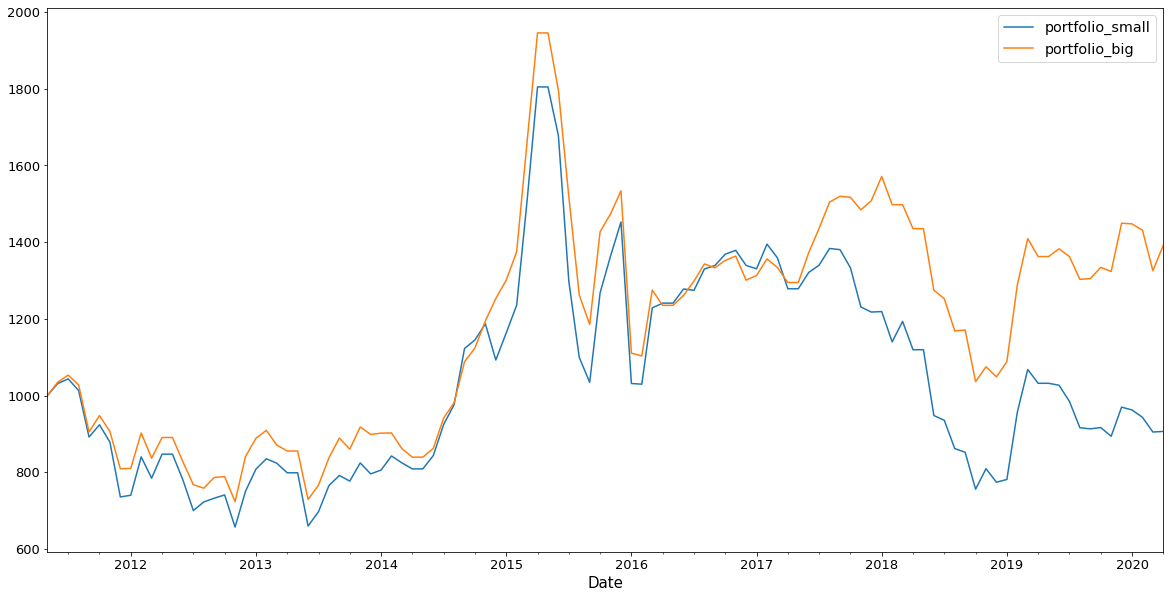

In [229]:
SMB.plot(x='Date', y=['portfolio_small', 'portfolio_big'], figsize=(20, 10))
plt.legend(fontsize=20)
plt.legend(fontsize="x-large")
#plt.title('Динамика рыночных стоимостей портфелей с высокой и низкой капитализацией в России', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.savefig('SMB Russia.png')

In [230]:
#SMB.to_excel('SMB Russia.xlsx')

Эффект стоимости (HML)

Поделить выборки на 30 - high BM - акции стоимости, 30 - low BM- акции роста
(Выше 70% квантиля и  до 30% квантиля соотвественно

In [231]:
# формирование портфелей для HML

high = pd.DataFrame(columns=list(data.columns))
low = pd.DataFrame(columns=list(data.columns))

for i in range(10):
    one_year = data[data['Date']==2010+i]
    
    quantile_h = one_year['BM'].quantile(0.7)
    quantile_l = one_year['BM'].quantile(0.3)
    
    high = high.append(one_year[one_year['BM']>=quantile_h])
    low = low.append(one_year[one_year['BM']<=quantile_l])
    
high = high[['Date', 'RIC']]
low = low[['Date', 'RIC']]

In [232]:
start_date = pd.to_datetime('31.05.2011', dayfirst=True)
low_p = pd.DataFrame(columns=list(prices.columns))
high_p = pd.DataFrame(columns=list(prices.columns))

for i in range(10):
    one_year = prices[(prices['Date'] >= start_date + pd.to_timedelta(i, unit='y')) &
           (prices['Date'] < start_date + pd.to_timedelta(i+1, unit='y'))]
    
    low_part = pd.merge(low[low['Date']==2010+i], one_year, how='left', on=['RIC'])
    del low_part['Date_x']
    low_part = low_part.rename(columns={'Date_y': 'Date'})
    low_p = low_p.append(low_part)
    
    high_part = pd.merge(high[high['Date']==2010+i], one_year, how='left', on=['RIC'])
    del high_part['Date_x']
    high_part = high_part.rename(columns={'Date_y': 'Date'})
    high_p = high_p.append(high_part)

In [233]:
# Новый расчёт портфелей

start_cap = 1000

high_result = pd.DataFrame()

for i in range(9):
    year = dates[i*12:12+i*12]
    year_p = pd.merge(year, high_p, how='left', on='Date')
    n = (pd.unique(year_p['RIC'])).shape[0]
    year_p = year_p.sort_values('Date')
    weights = year_p.head(n)
    weights['Weight'] = start_cap/n/weights['Price_close']
    year_p = pd.merge(year_p, weights, how='left', on='RIC')
    year_p = year_p[['Date_x', 'RIC', 'Price_close_x', 'Weight']]
    year_p = year_p.rename(columns={'Date_x': 'Date',
                                   'Price_close_x': 'Price_close'})
    year_p['Amount'] = year_p['Price_close'] * year_p['Weight']
    year_p = year_p[['Date', 'Amount']].groupby(by='Date').sum()
    year_p = year_p.reset_index()
    start_cap = year_p['Amount'].loc[11]
    
    high_result = high_result.append(year_p, ignore_index=True)

high_result.head(26)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,Amount
0,2011-05-31,1000.000000
1,2011-06-30,1019.995128
2,2011-07-31,1005.634923
3,2011-08-31,951.487281
4,2011-09-30,841.323680
5,2011-10-31,874.484827
6,2011-11-30,810.271918
7,2011-12-31,710.804858
8,2012-01-31,731.905747
9,2012-02-29,822.615089


In [234]:
# Новый расчёт портфелей

start_cap = 1000

low_result = pd.DataFrame()

for i in range(9):
    year = dates[i*12:12+i*12]
    year_p = pd.merge(year, low_p, how='left', on='Date')
    n = (pd.unique(year_p['RIC'])).shape[0]
    year_p = year_p.sort_values('Date')
    weights = year_p.head(n)
    weights['Weight'] = start_cap/n/weights['Price_close']
    year_p = pd.merge(year_p, weights, how='left', on='RIC')
    year_p = year_p[['Date_x', 'RIC', 'Price_close_x', 'Weight']]
    year_p = year_p.rename(columns={'Date_x': 'Date',
                                   'Price_close_x': 'Price_close'})
    year_p['Amount'] = year_p['Price_close'] * year_p['Weight']
    year_p = year_p[['Date', 'Amount']].groupby(by='Date').sum()
    year_p = year_p.reset_index()
    start_cap = year_p['Amount'].loc[11]
    
    low_result = low_result.append(year_p, ignore_index=True)

low_result.head(26)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,Amount
0,2011-05-31,1000.000000
1,2011-06-30,1047.781437
2,2011-07-31,1098.858773
3,2011-08-31,1106.083988
4,2011-09-30,971.832539
5,2011-10-31,1020.347132
6,2011-11-30,1004.637378
7,2011-12-31,870.641536
8,2012-01-31,849.345589
9,2012-02-29,956.941844


In [235]:
HML = pd.merge(low_result, high_result, on='Date')
HML = HML.rename(columns={'Amount_x': 'portfolio_low',
                         'Amount_y': 'portfolio_high'})
HML['HML'] = HML['portfolio_high'] - HML['portfolio_low']

HML['Low_Return'] = HML['portfolio_low'].pct_change() * 100
HML['High_Return'] = HML['portfolio_high'].pct_change() * 100
HML['HML Spread'] = HML['High_Return'] - HML['Low_Return']
HML.head(24)

,Date,portfolio_low,portfolio_high,HML,Low_Return,High_Return,HML Spread
0,2011-05-31,1000.000000,1000.000000,-1.136868e-13,NaN,NaN,NaN
1,2011-06-30,1047.781437,1019.995128,-2.778631e+01,4.778144e+00,1.999513e+00,-2.778631e+00
2,2011-07-31,1098.858773,1005.634923,-9.322385e+01,4.874808e+00,-1.407870e+00,-6.282678e+00
3,2011-08-31,1106.083988,951.487281,-1.545967e+02,6.575199e-01,-5.384423e+00,-6.041943e+00
4,2011-09-30,971.832539,841.323680,-1.305089e+02,-1.213755e+01,-1.157804e+01,5.595032e-01
5,2011-10-31,1020.347132,874.484827,-1.458623e+02,4.992073e+00,3.941544e+00,-1.050529e+00
6,2011-11-30,1004.637378,810.271918,-1.943655e+02,-1.539648e+00,-7.342941e+00,-5.803293e+00
7,2011-12-31,870.641536,710.804858,-1.598367e+02,-1.333773e+01,-1.227576e+01,1.061969e+00
8,2012-01-31,849.345589,731.905747,-1.174398e+02,-2.446006e+00,2.968591e+00,5.414597e+00
9,2012-02-29,956.941844,822.615089,-1.343268e+02,1.266814e+01,1.239358e+01,-2.745537e-01


In [236]:
# удаление месяца с выбросом

# HML = HML[HML['Date'] != '2016-05-31']

(array([ 500.,  750., 1000., 1250., 1500., 1750., 2000., 2250., 2500.,
        2750.]), <a list of 10 Text yticklabel objects>)

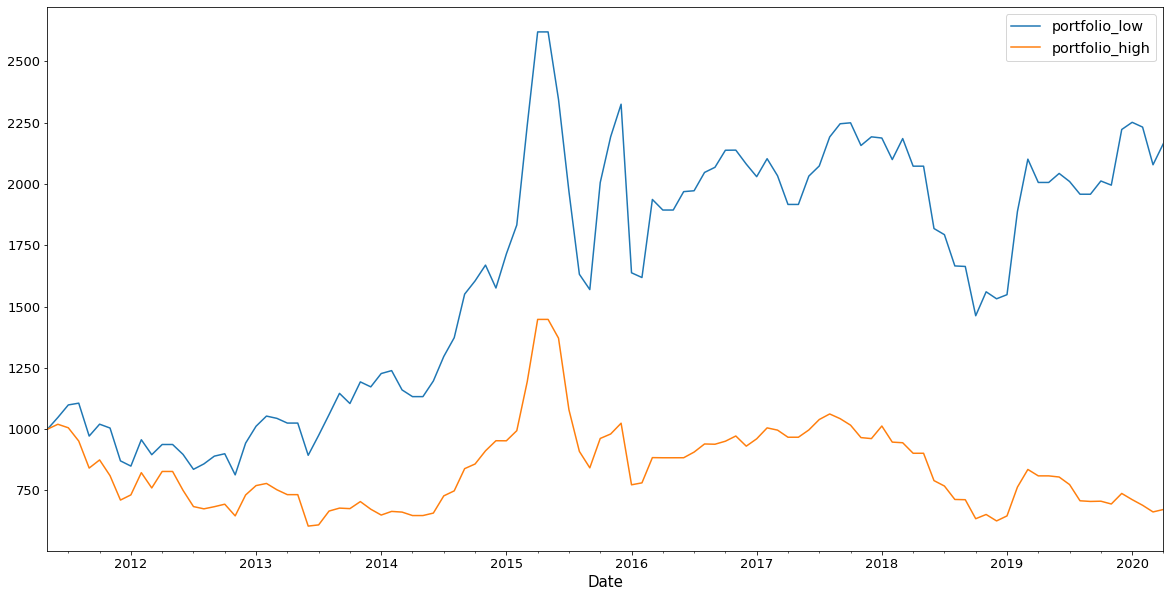

In [237]:
HML.plot(x='Date', y=['portfolio_low', 'portfolio_high'], figsize=(20, 10))
plt.legend(fontsize=20)
plt.legend(fontsize="x-large")
#plt.title('Динамика рыночных стоимостей портфелей акций стоимости и акций роста в России', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.savefig('HML Russia.png')

In [204]:
#HML.to_excel('HML Russia.xlsx')

In [238]:
# Подтягиваем рыночную премию за риск

premium = pd.read_excel('Raw_Dataset_3.xlsx',  sheet_name='Market Factor China', header=0)
premium['Date'] = pd.to_datetime(premium['Date'], dayfirst=True)
premium

,Date,Risk Free Rate,Market Return,Market Premium
0,2010-02-28,3.034864,2.110805,-0.924059
1,2010-03-31,-2.564181,1.872971,4.437152
2,2010-04-30,0.673529,-7.655943,-8.329472
3,2010-05-31,-0.173968,-9.741546,-9.567578
4,2010-06-30,-0.344635,-6.843803,-6.499168
...,...,...,...,...
126,2020-08-31,1.260412,4.490966,3.230554
127,2020-09-30,0.171130,-4.424156,-4.595286
128,2020-10-31,1.007390,1.664291,0.656901
129,2020-11-30,1.024207,7.039819,6.015612


In [239]:
# таблица с тремя факторами

allfactors = pd.merge(SMB[['Date', 'SMB Spread']], HML[['Date', 'HML Spread']], how='inner', on='Date')
allfactors = pd.merge(allfactors, premium[['Date', 'Market Premium']], how='inner', on='Date')
allfactors = allfactors.fillna(0)
allfactors

,Date,SMB Spread,HML Spread,Market Premium
0,2011-05-31,0.000000,0.000000,-6.032176
1,2011-06-30,-0.353242,-2.778631,-0.391964
2,2011-07-31,-0.606496,-6.282678,-0.680658
3,2011-08-31,-0.462032,-6.041943,-5.641737
4,2011-09-30,-0.048926,0.559503,-8.594297
...,...,...,...,...
103,2019-12-31,-1.014564,-5.176170,5.827521
104,2020-01-31,-0.635236,-4.739615,-3.660794
105,2020-02-29,-0.854810,-2.363686,-5.282403
106,2020-03-31,3.313562,2.945833,-4.906863


In [240]:
# построение исходного портфеля

all_p = data[['Date', 'RIC']]
all_p

,Date,RIC
0,2010,000002.SZ
1,2011,000002.SZ
2,2012,000002.SZ
3,2013,000002.SZ
4,2014,000002.SZ
...,...,...
12585,2015,900953.SS
12586,2016,900953.SS
12587,2017,900953.SS
12588,2018,900953.SS


In [241]:
start_date = pd.to_datetime('31.05.2011', dayfirst=True)
portfolio = pd.DataFrame(columns=list(prices.columns))

for i in range(10):
    one_year = prices[(prices['Date'] >= start_date + pd.to_timedelta(i, unit='y')) &
           (prices['Date'] < start_date + pd.to_timedelta(i+1, unit='y'))]
    
    portfolio_part = pd.merge(all_p[all_p['Date']==2010+i], one_year, how='left', on=['RIC'])
    del portfolio_part['Date_x']
    portfolio_part = portfolio_part.rename(columns={'Date_y': 'Date'})
    portfolio = portfolio.append(portfolio_part)

In [242]:
# Новый расчёт портфелей

start_cap = 1000

portfolio_result = pd.DataFrame()

for i in range(9):
    year = dates[i*12:12+i*12]
    year_p = pd.merge(year, portfolio, how='left', on='Date')
    n = (pd.unique(year_p['RIC'])).shape[0]
    year_p = year_p.sort_values('Date')
    weights = year_p.head(n)
    weights['Weight'] = start_cap/n/weights['Price_close']
    year_p = pd.merge(year_p, weights, how='left', on='RIC')
    year_p = year_p[['Date_x', 'RIC', 'Price_close_x', 'Weight']]
    year_p = year_p.rename(columns={'Date_x': 'Date',
                                   'Price_close_x': 'Price_close'})
    year_p['Amount'] = year_p['Price_close'] * year_p['Weight']
    year_p = year_p[['Date', 'Amount']].groupby(by='Date').sum()
    year_p = year_p.reset_index()
    start_cap = year_p['Amount'].loc[11]
    
    portfolio_result = portfolio_result.append(year_p, ignore_index=True)

portfolio_result.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date,Amount
0,2011-05-31,1000.000000
1,2011-06-30,1033.183826
2,2011-07-31,1048.445149
3,2011-08-31,1020.479152
4,2011-09-30,898.517517


In [243]:
portfolio_result['Return'] = portfolio_result['Amount'].pct_change() * 100
portfolio_result = portfolio_result.fillna(0)
portfolio_result = pd.merge(portfolio_result, premium[['Date', 'Risk Free Rate']], how='inner', on='Date')
portfolio_result['y_return'] = portfolio_result['Return'] - portfolio_result['Risk Free Rate']
portfolio_result = portfolio_result.rename(columns={'Amount': 'portfolio'})
portfolio_result

,Date,portfolio,Return,Risk Free Rate,y_return
0,2011-05-31,1000.000000,0.000000,0.420630,-0.420630
1,2011-06-30,1033.183826,3.318383,1.311517,2.006866
2,2011-07-31,1048.445149,1.477116,-1.086221,2.563337
3,2011-08-31,1020.479152,-2.667378,1.531690,-4.199069
4,2011-09-30,898.517517,-11.951409,0.487829,-12.439238
...,...,...,...,...,...
103,2019-12-31,1198.272376,9.025524,1.427860,7.597664
104,2020-01-31,1193.209317,-0.422530,1.605261,-2.027791
105,2020-02-29,1174.813461,-1.541712,1.299370,-2.841083
106,2020-03-31,1106.294922,-5.832291,-0.823182,-5.009109


(array([ 600.,  800., 1000., 1200., 1400., 1600., 1800., 2000.]),
 <a list of 8 Text yticklabel objects>)

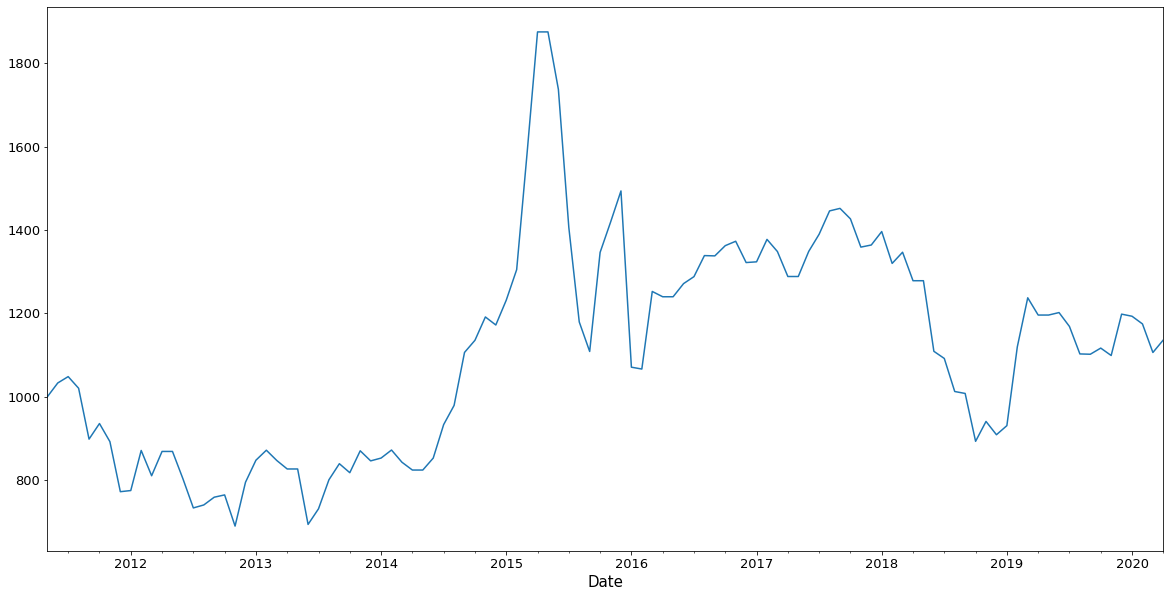

In [244]:
portfolio_result.plot(x='Date', y='portfolio', figsize=(20, 10), legend=None)
#plt.title('Динамика рыночной стоимости портфеля акций в России', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.savefig('portfolio Russia.png')

In [245]:
# трёхфакторная модель Фамы и Френча

model = pd.merge(allfactors, portfolio_result[['Date', 'y_return']], how='inner', on='Date')
model

,Date,SMB Spread,HML Spread,Market Premium,y_return
0,2011-05-31,0.000000,0.000000,-6.032176,-0.420630
1,2011-06-30,-0.353242,-2.778631,-0.391964,2.006866
2,2011-07-31,-0.606496,-6.282678,-0.680658,2.563337
3,2011-08-31,-0.462032,-6.041943,-5.641737,-4.199069
4,2011-09-30,-0.048926,0.559503,-8.594297,-12.439238
...,...,...,...,...,...
103,2019-12-31,-1.014564,-5.176170,5.827521,7.597664
104,2020-01-31,-0.635236,-4.739615,-3.660794,-2.027791
105,2020-02-29,-0.854810,-2.363686,-5.282403,-2.841083
106,2020-03-31,3.313562,2.945833,-4.906863,-5.009109


In [246]:
# CAPM Model

X = np.array(model['Market Premium'])
Y = np.array(model['y_return'])
X = sm.add_constant(X)

CAPM_OLS = sm.OLS(Y, X)
result_OLS = CAPM_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     301.1
Date:                Fri, 07 May 2021   Prob (F-statistic):           9.49e-33
Time:                        16:47:23   Log-Likelihood:                -299.88
No. Observations:                 108   AIC:                             603.8
Df Residuals:                     106   BIC:                             609.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3001      0.378      0.795      0.4

In [247]:
ols_resid = result_OLS.resid
resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
print(resid_fit.tvalues[1])
print(resid_fit.pvalues[1])

0.684700400322469
0.49504161904640465


In [248]:
rho = resid_fit.params[1]
order = toeplitz(range(len(ols_resid)))

sigma = rho**order
CAPM_GLS = sm.GLS(Y, X, sigma=sigma)
result_GLS = CAPM_GLS.fit()
print(result_GLS.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            GLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     294.3
Date:                Fri, 07 May 2021   Prob (F-statistic):           2.33e-32
Time:                        16:47:27   Log-Likelihood:                -299.64
No. Observations:                 108   AIC:                             603.3
Df Residuals:                     106   BIC:                             608.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3029      0.403      0.751      0.4

In [249]:
# 3FF Model

X = model[['SMB Spread', 'HML Spread', 'Market Premium']].values
X = sm.add_constant(X)
Y = np.array(model['y_return'])

FF_OLS = sm.OLS(Y, X)
result_OLS = FF_OLS.fit()
print(result_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     420.3
Date:                Fri, 07 May 2021   Prob (F-statistic):           5.71e-58
Time:                        16:47:29   Log-Likelihood:                -233.53
No. Observations:                 108   AIC:                             475.1
Df Residuals:                     104   BIC:                             485.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0428      0.220      0.194      0.8

In [250]:
ols_resid = result_OLS.resid
resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
print(resid_fit.tvalues[1])
print(resid_fit.pvalues[1])

-0.5589594199856334
0.5773796223462941


In [251]:
rho = resid_fit.params[1]
order = toeplitz(range(len(ols_resid)))

sigma = rho**order
FF_GLS = sm.GLS(Y, X, sigma=sigma)
result_GLS = FF_GLS.fit()
print(result_GLS.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            GLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     432.2
Date:                Fri, 07 May 2021   Prob (F-statistic):           1.49e-58
Time:                        16:47:37   Log-Likelihood:                -233.37
No. Observations:                 108   AIC:                             474.7
Df Residuals:                     104   BIC:                             485.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0423      0.211      0.201      0.8